# Flow 圖片分類模型 (Keras 架構 PyTorch 實現)
此程式碼已根據提供的 Keras 腳本進行結構調整。
主要變更包含：
1.  資料處理：從讀取 2D 圖片改為處理 1D 序列資料，以模擬封包數據。
2.  模型架構：採用 Keras 版本中的 TimeDistributed CNN + LSTM 結構。
    - 實作了 Byte-level CNN (`ByteBlock`)。
    - 透過 reshape 操作模擬 Keras 中的 `TimeDistributed` 功能。
    - 整合了兩個並行的 CNN block 並將其輸出串接。
3.  訓練流程：保留了原有的 PyTorch 訓練迴圈，但套用了新的模型。

By Gemini

In [ ]:
# ==============================================================================
# 參數定義
# ==============================================================================
from sympy import false

# 圖片/封包參數 (參照 Keras 程式碼中的 PACKET_NUM_PER_SESSION 和 PACKET_LEN)
# n_pkts 代表每個 session 有幾張圖 (封包)
# m_bytes 代表每張圖攤平後的大小 (每個封包的 byte 數)
n_pkts = 6
m_bytes = 100 * 256  # 假設原始圖片為 100*256，將其攤平為一維序列

# 模型訓練參數
EPOCHS = 10  # 增加 Epochs 以獲得更好的訓練效果
BatchSize = 128  # 根據模型複雜度和記憶體調整 BatchSize
Learning_Rate = 1e-2  # 調整學習率以獲得更穩定的訓練效果
NUM_CLASSES = 9  # 請根據你的資料集類別數進行調整

# 資料集位置
DATASET_PATH = '/home/user/Flow2img2/DataSet'
TESTSET_PATH = '/home/user/Flow2img2/TestSet'


In [ ]:
# ==============================================================================
# 1. 函式庫導入與環境設定
# ==============================================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F # 需要匯入 softmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 設定 device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [11]:
# %%
# ==============================================================================
# 2. 資料集定義與載入 (修正版)
# ==============================================================================
# 根據正確的理解：圖片本身就是 (256, 100) 的 one-hot 編碼表示
class FlowPacketDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.class_map = {}
        self.transform = transform

        if not os.path.isdir(root_dir):
            raise ValueError(f"提供的路徑不存在: {root_dir}")

        label_dirs = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

        for idx, label_name in enumerate(label_dirs):
            label_path = os.path.join(root_dir, label_name)
            self.class_map[label_name] = idx

            session_folders = sorted([d for d in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, d))])
            for session_folder in session_folders:
                session_path = os.path.join(label_path, session_folder)

                imgs_paths = [os.path.join(session_path, f"{i}.png") for i in range(n_pkts)]

                if all(os.path.exists(p) for p in imgs_paths):
                    self.samples.append((imgs_paths, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_paths, label = self.samples[idx]

        # 載入 n_pkts 張圖片
        sequences = []
        for p in img_paths:
            # 讀取灰階圖片
            img = Image.open(p).convert('L')
            if self.transform:
                sequences.append(self.transform(img))

        sequences = torch.stack(sequences)
        return sequences, torch.tensor(label, dtype=torch.long)

# 只需要 ToTensor，它會將 (H, W) 的 PIL Image 轉為 (1, H, W) 的 Tensor
# H=256, W=100
transform = transforms.Compose([
    transforms.ToTensor()
])

# 重新定義 m_bytes (這裡改名為 packet_len 更合適)
packet_len = 100 # 圖片寬度
byte_values = 256 # 圖片高度

dataset = FlowPacketDataset(os.path.join(DATASET_PATH), transform = transform)
testset = FlowPacketDataset(os.path.join(TESTSET_PATH), transform = transform)
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])
test_size = len(testset)
# 增加 workers 增加 Process 先將資料處理放到 RAM 中，使 GPU 載入資料速度變快，減少閒置
# 不過調整 workers 的數量可以在 GPU 的處理速度以及 RAM 的使用量中取得平衡
train_loader = DataLoader(trainset, batch_size = BatchSize, shuffle = True, num_workers = 4)
valset_loader = DataLoader(valset, batch_size = BatchSize, shuffle= True, num_workers = 4)
test_loader = DataLoader(testset, batch_size = BatchSize, shuffle= True, num_workers = 4)

In [ ]:
# %%
# ==============================================================================
# 3. 模型定義 (最終修正版)
# ==============================================================================

# Keras `GlobalMaxPool1D` 的 PyTorch 實現
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()
    def forward(self, x):
        return torch.max(x, dim=2)[0]

# 對應 Keras `byte_block` 的 PyTorch Module
class ByteBlock(nn.Module):
    def __init__(self, in_channels, nb_filter, filter_length, subsample, pool_length):
        super().__init__()
        layers = []
        for i in range(len(nb_filter)):
            current_in_channels = in_channels if i == 0 else nb_filter[i-1]
            layers.append(nn.Conv1d(in_channels=current_in_channels,
                                    out_channels=nb_filter[i],
                                    kernel_size=filter_length[i],
                                    stride=subsample[i],
                                    padding='valid'))
            layers.append(nn.Tanh())
            if pool_length[i]:
                layers.append(nn.MaxPool1d(kernel_size=pool_length[i]))

        self.features = nn.Sequential(*layers)
        self.pool = GlobalMaxPool1d()
        self.fc = nn.Linear(nb_filter[-1], 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x)
        return self.relu(x)

# 模擬 Keras `TimeDistributed` 的 Packet Encoder
class PacketEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # Keras 模型的 one-hot 維度是 256，對應我們圖片的高度
        # 我們直接將這個維度作為 Conv1d 的 in_channels
        self.block2 = ByteBlock(in_channels=in_channels, nb_filter=(128, 256), filter_length=(5, 5), subsample=(1, 1), pool_length=(2, 2))
        self.block3 = ByteBlock(in_channels=in_channels, nb_filter=(192, 320), filter_length=(7, 5), subsample=(1, 1), pool_length=(2, 2))

    def forward(self, x):
        # 輸入 x 的 shape: (Batch * n_pkts, 1, 256, 100)

        # Conv1d 需要的輸入是 (Batch, Channels, Length)
        # 我們的圖片格式是 (1, H, W)，其中 H=256 是 Channels，W=100 是 Length
        # 所以我們需要移除 channel=1 這個維度
        x = x.squeeze(1) # -> shape: (Batch * n_pkts, 256, 100)

        # 現在資料格式正確，可以直接送入 ByteBlock
        out2 = self.block2(x)
        out3 = self.block3(x)

        # 串接結果
        return torch.cat([out2, out3], dim=-1)

# 主模型：CNN + LSTM (Keras 架構)
class KerasStyleCnnRnn(nn.Module):
    def __init__(self, num_classes, in_channels, lstm_units=92):
        super().__init__()
        self.encoder = PacketEncoder(in_channels=in_channels)

        # 取得 encoder 的輸出維度
        dummy_input = torch.zeros(1, 1, in_channels, packet_len) # (B, C, H, W)
        encoder_output_dim = self.encoder(dummy_input).shape[-1]

        self.lstm1 = nn.LSTM(input_size=encoder_output_dim, hidden_size=lstm_units, batch_first=True, num_layers=1, dropout=0.1)
        self.lstm2 = nn.LSTM(input_size=lstm_units, hidden_size=lstm_units, batch_first=True, num_layers=1, dropout=0.1)
        self.classifier = nn.Linear(lstm_units, num_classes)

    def forward(self, x):
        # x shape: (Batch, n_pkts, 1, 256, 100)
        B, T, C, H, W = x.shape

        # 模擬 TimeDistributed: 將時間維度和批次維度合併
        x_reshaped = x.view(B * T, C, H, W)

        encoded_seq = self.encoder(x_reshaped)

        # 將維度還原，以符合 LSTM 輸入格式 (Batch, Seq, Feature)
        encoded_seq = encoded_seq.view(B, T, -1)

        lstm_out, _ = self.lstm1(encoded_seq)
        lstm_out, _ = self.lstm2(lstm_out)

        final_out = lstm_out[:, -1, :]

        return self.classifier(final_out)

# 建立模型實例
# byte_values (256) 就是我們 Conv1d 的 in_channels
model = KerasStyleCnnRnn(num_classes=NUM_CLASSES, in_channels=byte_values).to(device)
print(model)

# 損失函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=Learning_Rate, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [5]:
# ==============================================================================
# 4. 訓練 & 測試函式 (沿用原有架構)
# ==============================================================================
def train_epoch(loader):
    model.train()
    total_loss = 0
    total_correct = 0
    for seqs, labels in loader:
        seqs, labels = seqs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * seqs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc


def eval_model(loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            
            preds = outputs.argmax(1)
            probs = F.softmax(outputs, dim=1) # 取得 softmax 機率
            total_correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()) # 收集機率值

    return total_loss/len(loader.dataset), total_correct/len(loader.dataset), all_preds, all_labels, all_probs


def evaluate_open_set(loader, num_known_classes, threshold=0.9):
    """
    在包含未知類別的測試集上評估模型，並使用信心閾值識別未知類別。
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

#將模型的輸出轉換為機率
            probabilities = F.softmax(outputs, dim=1)

#獲取最大機率及其對應的預測類別
            max_probs, preds = torch.max(probabilities, 1)

#如果最大機率小於我們的閾值，就將預測改為 "未知"
#我們用 num_known_classes 這個索引來代表 "未知"
            preds[max_probs < threshold] = num_known_classes

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels 


In [6]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_acc = 0
for ep in range(1, EPOCHS+1):
    tl, ta = train_epoch(train_loader)
    vl, va, _, _, _ = eval_model(valset_loader)
    train_losses.append(tl); train_accs.append(ta)
    val_losses.append(vl); val_accs.append(va)
    scheduler.step(vl) # 根據 val_loss 來調整 LRate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {ep}, train_loss={tl:.4f}, train_acc={ta:.4f}, val_acc={va:.4f}, now_lr={current_lr:.6f}")
    if va > best_acc:
        best_acc = va
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1, train_loss=2.1949, train_acc=0.1295, val_acc=0.1306, now_lr=0.010000
Epoch 2, train_loss=2.1691, train_acc=0.1515, val_acc=0.2830, now_lr=0.010000
Epoch 3, train_loss=0.8509, train_acc=0.6685, val_acc=0.9392, now_lr=0.010000
Epoch 4, train_loss=0.1459, train_acc=0.9358, val_acc=0.9407, now_lr=0.010000
Epoch 5, train_loss=0.1755, train_acc=0.9244, val_acc=0.9423, now_lr=0.010000
Epoch 6, train_loss=0.1260, train_acc=0.9343, val_acc=0.6585, now_lr=0.010000
Epoch 7, train_loss=0.1498, train_acc=0.9299, val_acc=0.9410, now_lr=0.010000
Epoch 8, train_loss=0.1097, train_acc=0.9379, val_acc=0.9394, now_lr=0.010000
Epoch 9, train_loss=0.1068, train_acc=0.9389, val_acc=0.9398, now_lr=0.010000
Epoch 10, train_loss=0.1054, train_acc=0.9392, val_acc=0.9460, now_lr=0.010000


plotting learning curve...


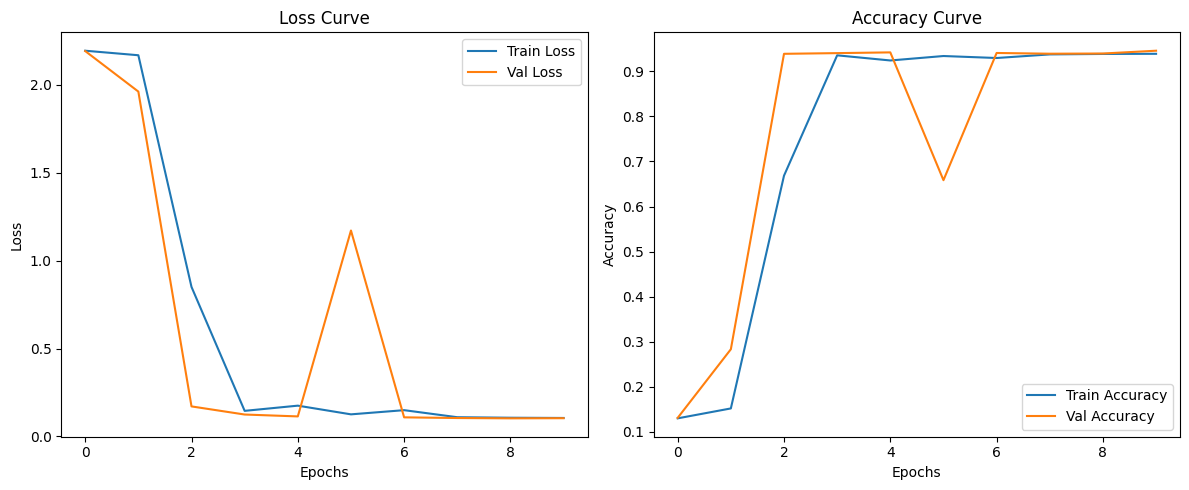

\n==================================================
Classification Report (Accuracy, Recall, F1-score)
Overall Test Accuracy: 0.9394\n
                  precision    recall  f1-score   support

          Benign     0.9783    0.9913    0.9848      3000
       DDoS_HOIC     0.9988    0.9988    0.9988      2500
  DDoS_LOIC_HTTP     1.0000    0.9976    0.9988      2500
   DoS_GoldenEye     0.9980    0.9916    0.9948      2500
        DoS_Hulk     1.0000    0.9996    0.9998      2500
DoS_SlowHTTPTest     0.7062    0.8632    0.7768      2500
   DoS_Slowloris     0.9716    0.9856    0.9786      2500
  FTP_BruteForce     0.8199    0.6300    0.7125      2500
  SSH_Bruteforce     0.9984    0.9864    0.9924      2500

        accuracy                         0.9394     23000
       macro avg     0.9412    0.9382    0.9375     23000
    weighted avg     0.9420    0.9394    0.9385     23000

\n==================================================
Plotting ROC Curve...


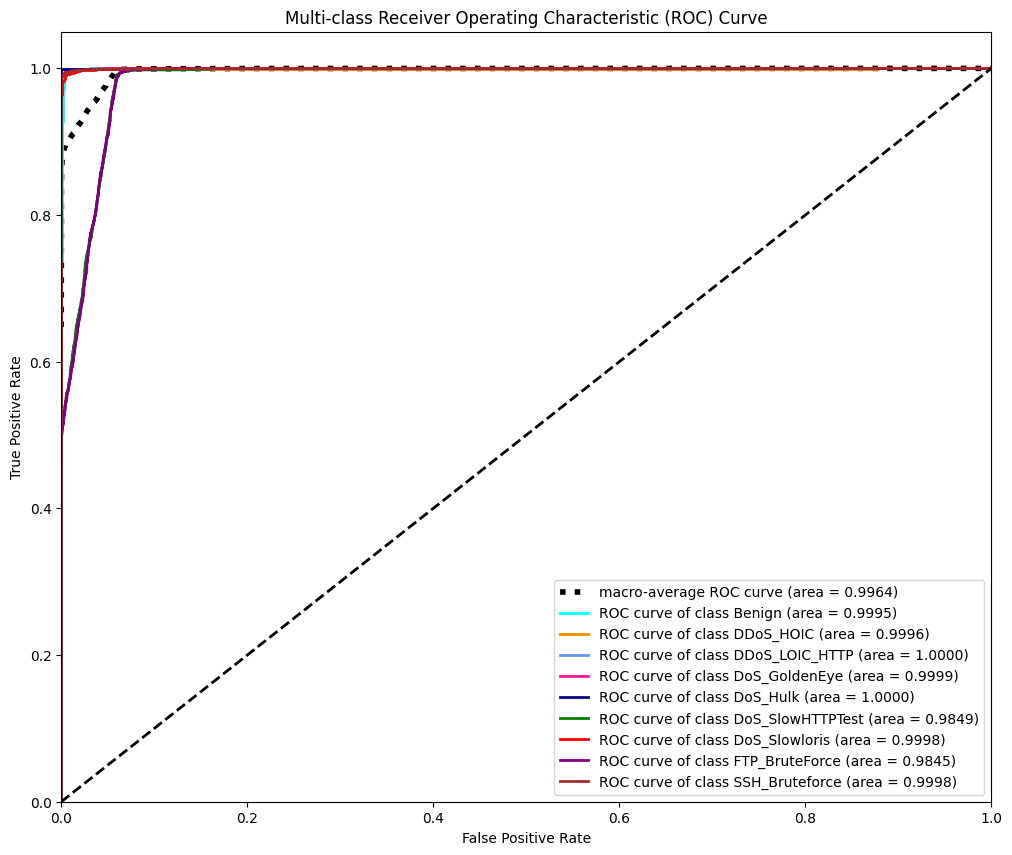

In [7]:
# 重新載入訓練過程中儲存的最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 使用測試集進行最終評估
test_loss, test_acc, test_preds, test_trues, test_probs = eval_model(test_loader)

# 獲取類別標籤
class_labels = list(dataset.class_map.keys())
num_classes = len(class_labels)

# ================================================================
# 1. 學習曲線 (Learning Curve) - Loss & Accuracy
# ================================================================
print("plotting learning curve...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# ================================================================
# 2. 分類報告 (Classification Report) - Accuracy, Recall, F1-score
# ================================================================
print("\\n" + "="*50)
print("Classification Report (Accuracy, Recall, F1-score)")
print("="*50)
print(f"Overall Test Accuracy: {test_acc:.4f}\\n")
# target_names 對應到標籤名稱
print(classification_report(test_trues, test_preds, target_names=class_labels, digits=4))


# ================================================================
# 3. ROC 曲線 (ROC Curve)
# ================================================================
print("\\n" + "="*50)
print("Plotting ROC Curve...")
print("="*50)

# 將真實標籤進行 one-hot 編碼
y_test_bin = label_binarize(test_trues, classes=list(range(num_classes)))
y_score = np.array(test_probs)

# 計算每個類別的 ROC 曲線和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 計算宏平均 (macro-average) ROC 曲線和 AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 繪製所有類別的 ROC 曲線
plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'green', 'red', 'purple', 'brown', 'gray'])

# 繪製宏平均 ROC 曲線
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.4f})',
         color='black', linestyle=':', linewidth=4)

# 繪製每個類別的 ROC 曲線
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

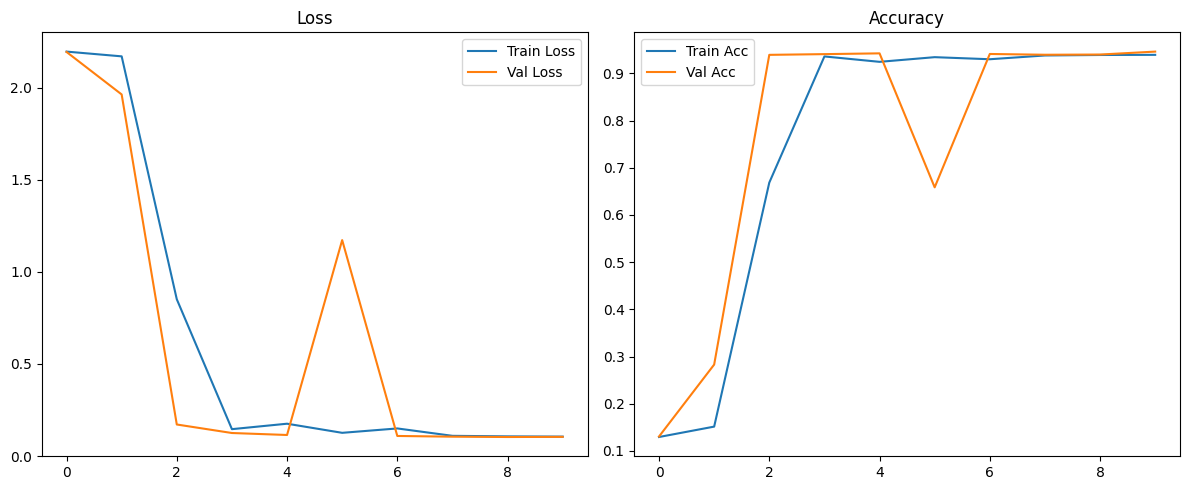

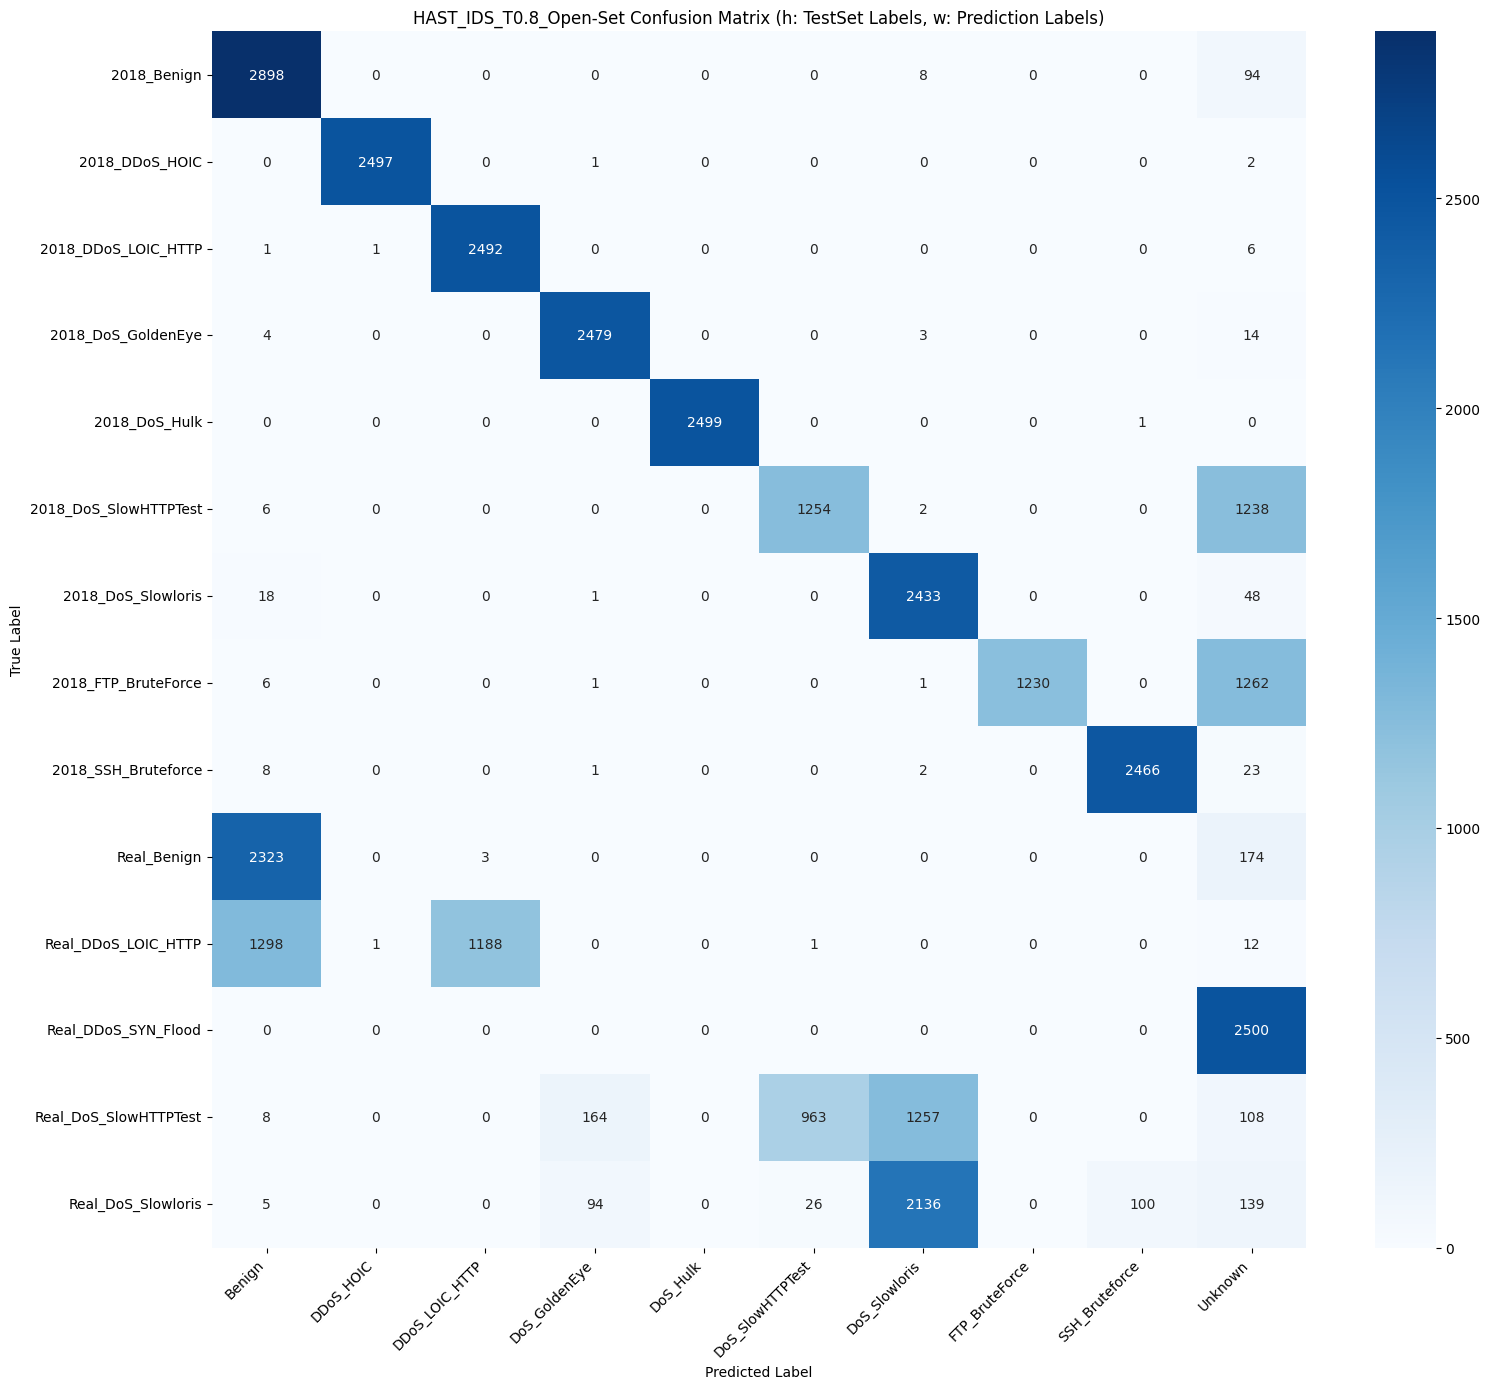

In [14]:
# ==============================================================================
# 6. 繪圖與混淆矩陣 (沿用原有架構)
# ==============================================================================
# 繪製 Loss & Accuracy 曲線
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

# 繪製混淆矩陣
#重新載入訓練過程中儲存的最佳模型
#確保您有執行過訓練迴圈並且 'best_model.pth' 已儲存
model.load_state_dict(torch.load('best_model.pth'))

#定義信心閾值
CONF_THRESHOLD = 0.8

##橫軸 (w): 模型的預測標籤 = 訓練時的已知類別 + "Unknown"
pred_labels = list(dataset.class_map.keys())
pred_labels.append('Unknown')

#縱軸 (h): 測試集的所有真實標籤
#我們需要一個排序過的字典，以確保標籤和索引對應
true_label_map = dict(sorted(testset.class_map.items(), key=lambda item: item[1]))
true_labels = list(true_label_map.keys())

#獲取預測結果
#已知類別的數量由 dataset (訓練資料) 決定
num_known_classes = len(dataset.class_map)
preds, trues = evaluate_open_set(test_loader, num_known_classes, threshold=CONF_THRESHOLD)

#生成並 "裁剪" 混淆矩陣
#sklearn.metrics.confusion_matrix 會生成一個方陣，其大小取決於 trues 和 preds 中的最大索引值。
#這會導致矩陣包含我們不需要的空白行或列。
#因此，我們生成它，然後立即將其裁剪成我們需要的準確形狀。
cm_full = confusion_matrix(trues, preds)

#我們的矩陣形狀應該是: (測試集真實標籤數) x (模型預測標籤數)
num_true_labels = len(true_labels)
num_pred_labels = len(pred_labels)

#進行裁剪
cm = cm_full[:num_true_labels, :num_pred_labels]

#繪製客製化的混淆矩陣
plt.figure(figsize=(16, 14)) # 可能需要更大的畫布
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pred_labels, # 橫軸標籤
            yticklabels=true_labels)  # 縱軸標籤
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'HAST_IDS_T{CONF_THRESHOLD}_Open-Set Confusion Matrix (h: TestSet Labels, w: Prediction Labels)')
#旋轉橫軸標籤，避免重疊
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # 自動調整佈局
plt.show()

In [ ]:
# 儲存模型到本地中
save_path = Path(f"/Final_Compare/HAST_IDS/n{n_pkts}_m{m_bytes}_")
save_path.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), f"{save_path}/HAST_IDS_n{n_pkts}_m{m_bytes}_.pth")
torch.save(model, f"{save_path}/HAST_IDS_complete_model_n{n_pkts}_m{m_bytes}_.pth")